In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from generation.nets.abstract_net import AbstractGenerator, AbstractDiscriminator
from generation.config import SIGNAL_DIM, DETECTORS, POSTPROCESSED_SIGNALS_PATH

In [240]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     - 13.4 MB 629 kB/s
  Created wheel for Theano: filename=Theano-1.0.5+unknown-py3-none-any.whl size=2667282 sha256=00286cb65593e0fc4b3d5ef76503419f2120d0540ff43ce3bb9fc1394e826227
  Stored in directory: /tmp/pip-ephem-wheel-cache-cihxk1tb/wheels/d1/38/85/558fc0e4d0c26db812304f163e348fb242767d3ea27da937fe
Successfully built Theano
     | 231 kB 862 kB/ss
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-py3-none-any.whl size=122798 sha256=7e61a40f6095849c6131d1ea461bbbd666702d3001c9a0f9ea2d5dd95a632c3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xioxcc8u/wheels/b6/a5/97/c657632d2b7fcff539623ea56996e09ec3c83c871e25a62cc5
Successfully built Lasagne


In [230]:
class MyDataset(Dataset):
    def __init__(self, detectors=DETECTORS, signal_dim=SIGNAL_DIM, freq=1):
        self.detectors = detectors
        self.signal_dim = signal_dim
        self.freq = freq
        
        self.signals = np.load(POSTPROCESSED_SIGNALS_PATH)       
        self.amplitudes = self._get_amplitudes()
        self.ref_times = self._get_ref_times()
        
    def _get_amplitudes(self):
        amplitudes = np.max(self.signals, axis=2)
        amplitudes /= np.max(amplitudes, axis=1)[:, None]
        return amplitudes
    
    def _get_ref_times(self):
        ref_times = np.zeros(self.amplitudes.shape)
        for detector_idx in range(ref_times.shape[0]):
            for signal_idx in range(ref_times.shape[1]):
                ref_times[detector_idx][signal_idx] = self._get_ref_time_pred(self.signals[detector_idx][signal_idx])
        np.nan_to_num(ref_times, 0)
        ref_times /= np.max(ref_times, axis=1)[:, None]
        return ref_times
        
    @staticmethod
    def _get_ref_time_pred(signal):
        half_amplitude = np.min(signal) + (np.max(signal) - np.min(signal)) / 2
        for idx, cur_amplitude in enumerate(signal):
            if cur_amplitude > half_amplitude:
                return idx

    def __len__(self):
        return self.signals.shape[1]

    def __getitem__(self, idx):
        detector_times = self.ref_times[:, idx]
        detector_amplitudes = self.amplitudes[:, idx]
        
        features = np.concatenate([detector_times, detector_amplitudes], axis=0)
        
        tensor = torch.from_numpy(features)
        return tensor.float()


In [247]:
class Generator(AbstractGenerator):
    def __init__(self, config):
        super(Generator, self).__init__(config)
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']

        self.final = nn.Sequential(
            nn.Linear(self.z_dim, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Linear(32, self.x_dim),
            nn.ReLU()
        )
        
        
    def forward(self, x, debug=False):
        out = self.final(x)
        return out
        
        
    @staticmethod
    def get_rel_fake_fig(real_sample, fake_sample):
        real_sample = real_sample.cpu().data
        fake_sample = fake_sample.cpu().data

        plt.clf()
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        ax[0][0].set_title("Real times")
        ax[0][0].plot(real_sample[:9])
        ax[0][1].set_title("Fake times")
        ax[0][1].plot(fake_sample[:9])
        ax[1][0].set_title("Real amplitudes")
        ax[1][0].plot(real_sample[9:])
        ax[1][1].set_title("Fake amplitudes")
        ax[1][1].plot(fake_sample[9:])
        return fig

In [248]:
from generation.inference import InferenceModel

In [266]:
model = InferenceModel(Generator, "1jg8uan3", epoch=480)

2021-03-10 20:20:13.394 | INFO     | generation.inference.inference_model:_load_checkpoint:25 - Restored checkpoint from epoch 480


In [267]:
z = torch.randn(1, model.config['z_dim'])
z = z.to(model.config['device'])
model.generator(z)

tensor([[0.6758, 0.3584, 0.1753, 0.4140, 0.4849, 0.3358, 0.3067, 0.4163, 0.2655,
         0.0617, 0.0000, 0.0000, 0.1276, 0.5213, 0.1319, 0.1157, 0.0293, 0.0827]],
       device='cuda:3', grad_fn=<ReluBackward0>)

In [268]:
samples_num = 1024

fake = model.generate(samples_num).cpu().numpy()

dataset = MyDataset()
idxs = np.random.choice(range(len(dataset)), samples_num)
real = [dataset[idx].numpy() for idx in idxs]

In [269]:
real[0].shape

(18,)

In [270]:
fake_times = np.array([item[:9] for item in fake])
fake_amplitudes = np.array([item[9:] for item in fake])

real_times = np.array([item[:9] for item in real])
real_amplitudes = np.array([item[9:] for item in real])

In [273]:
real_amplitudes.shape

(1024, 9)

In [275]:
np.corrcoef(real_amplitudes[i], real_amplitudes[j])

array([[1., 1.],
       [1., 1.]])

In [280]:
def get_amplitude_correlations(amplitudes):
    correlations = np.zeros((9, 9))
    for i in range(9):
        for j in range(9):
            correlations[i][j] = round(np.corrcoef(amplitudes[i], amplitudes[j])[0][1], 2)
    return correlations

In [285]:
np.mean(np.abs(get_amplitude_correlations(real_amplitudes) - get_amplitude_correlations(fake_amplitudes)))

0.13135802469135802

In [282]:
get_amplitude_correlations(fake_amplitudes)

array([[1.  , 0.94, 0.97, 0.93, 0.98, 0.92, 0.95, 0.96, 0.96],
       [0.94, 1.  , 0.93, 1.  , 0.95, 0.9 , 0.94, 0.97, 0.96],
       [0.97, 0.93, 1.  , 0.92, 0.99, 0.93, 0.94, 0.96, 0.93],
       [0.93, 1.  , 0.92, 1.  , 0.94, 0.89, 0.92, 0.96, 0.96],
       [0.98, 0.95, 0.99, 0.94, 1.  , 0.92, 0.95, 0.95, 0.95],
       [0.92, 0.9 , 0.93, 0.89, 0.92, 1.  , 0.99, 0.93, 0.93],
       [0.95, 0.94, 0.94, 0.92, 0.95, 0.99, 1.  , 0.96, 0.95],
       [0.96, 0.97, 0.96, 0.96, 0.95, 0.93, 0.96, 1.  , 0.94],
       [0.96, 0.96, 0.93, 0.96, 0.95, 0.93, 0.95, 0.94, 1.  ]])

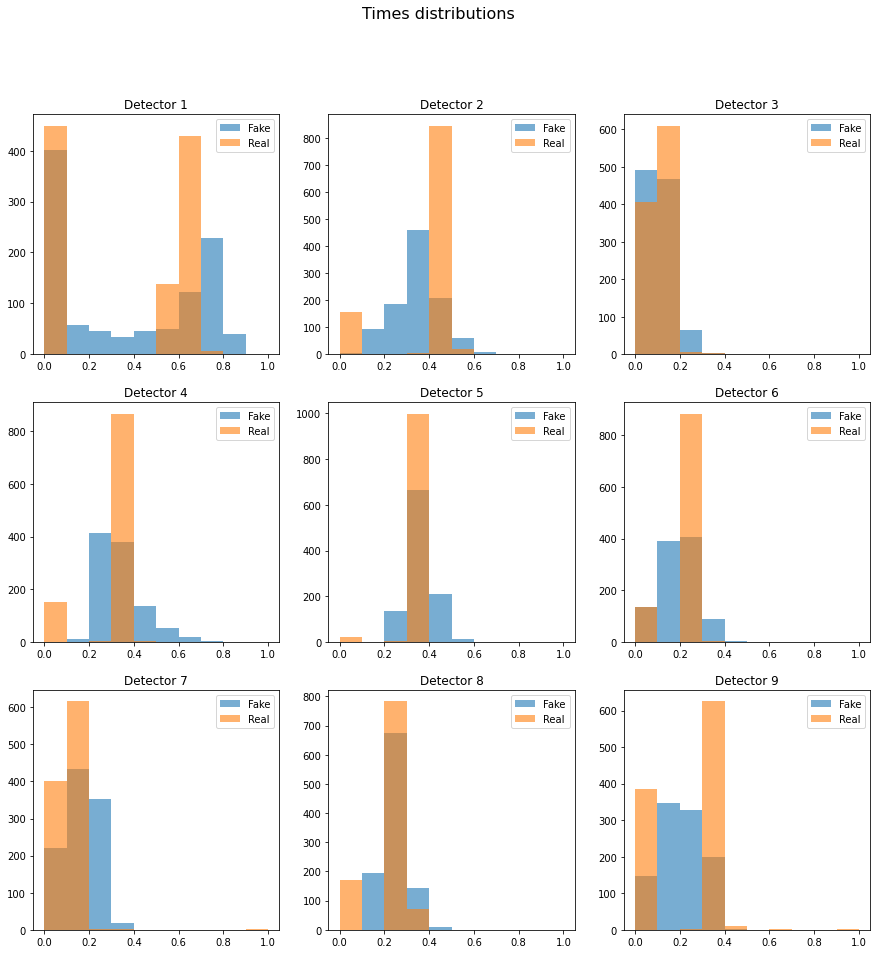

In [271]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Times distributions", fontsize=16)

time_bins = [x for x in np.arange(0, 1.1, 0.1)]

for i in range(9):
    ax[i // 3][i % 3].set_title(f"Detector {i + 1}")
    ax[i // 3][i % 3].hist(fake_times[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].hist(real_times[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].legend(['Fake', 'Real'])

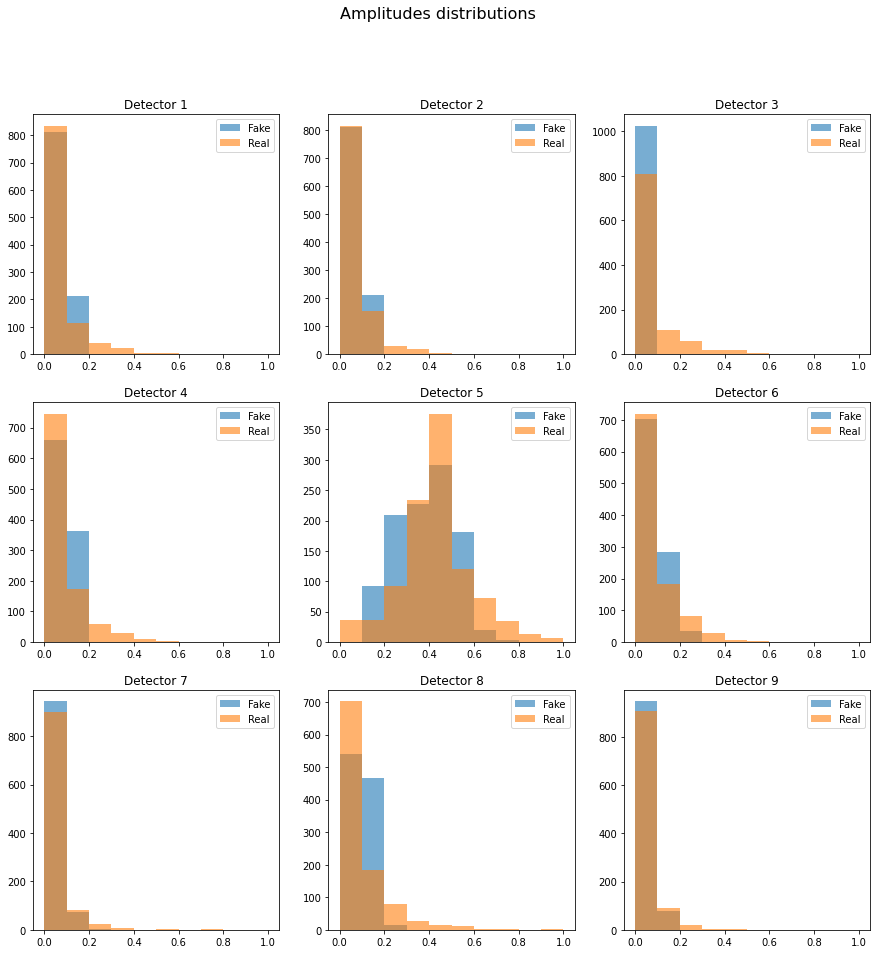

In [272]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Amplitudes distributions", fontsize=16)

time_bins = [x for x in np.arange(0, 1.1, 0.1)]

for i in range(9):
    ax[i // 3][i % 3].set_title(f"Detector {i + 1}")
    ax[i // 3][i % 3].hist(fake_amplitudes[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].hist(real_amplitudes[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].legend(['Fake', 'Real'])